# Import modules

In [1]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import LearningRateScheduler
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

Using TensorFlow backend.


In [0]:
def lr_schedule(epoch):
    lrate=0.001
    if epoch > 50:
      lrate=0.0005
    if epoch > 80:
      lrate=0.0001
    if epoch > 100:
      lrate=0.00001
    return lrate

# Tuning parameters

In [0]:
epochs = 110
learning_rate=0.0001

In [0]:
batch_size = 100
num_classes = 10
data_augmentation = True

# Data

## Plot image

In [0]:
def plot_images(x, y_true, y_pred=None, size=(5, 5)):
    assert len(x) == len(y_true) == size[0] * size[1]
    
    fig, axes = plt.subplots(size[0], size[1])
    fig.subplots_adjust(hspace=0.5, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        if x[i].shape[-1] == 1:
          ax.imshow(x[i].reshape(x[i].shape[0], x[i].shape[1]))
        else:
          ax.imshow(x[i])

        if y_pred is None:
            xlabel = "True: {0}".format(y_true[i].argmax())
        else:
            xlabel = "True: {0}, Pred: {1}".format(y_true[i].argmax(), 
                                                   y_pred[i].argmax())

        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

## Load dataset

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

## Reshaping the data

In [0]:
if len(x_train.shape) < 4:
  x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
  x_test = x_test.reshape(x_test.shape[0], x_train.shape[1], x_train.shape[2], 1)

In [8]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


## Applying One hot encoding for the data

In [0]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Show data

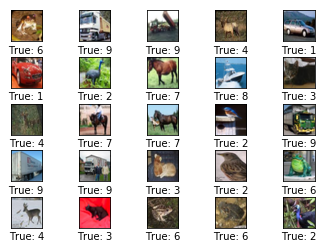

In [10]:
plot_images(x_train[:25], y_train[:25])

# Creating the DNN model

In [0]:
model = Sequential()

## Adding layers to the model

In [12]:
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='linear', 
                 input_shape=x_train.shape[1:]))
model.add(LeakyReLU(alpha=.01))
model.add(Conv2D(128, (3, 3), activation='linear'))
model.add(LeakyReLU(alpha=.001))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same', activation='linear'))
model.add(LeakyReLU(alpha=.01))
model.add(Conv2D(512, (3, 3), activation='linear'))
model.add(LeakyReLU(alpha=.01))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='linear'))
model.add(LeakyReLU(alpha=.01))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

if data_augmentation:
  datagen = ImageDataGenerator(
                            # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)
  datagen.fit(x_train)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Visualization the model

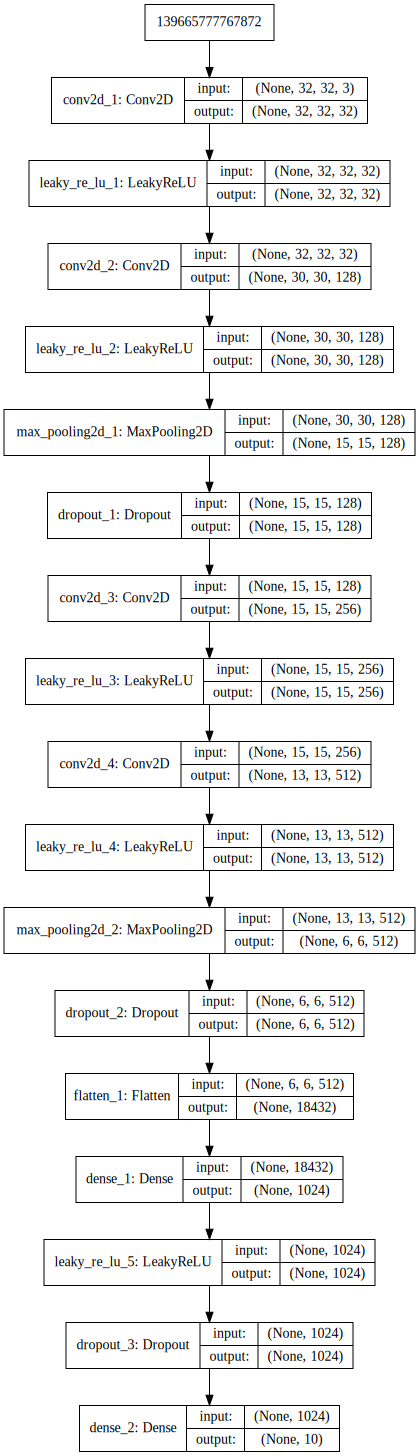

In [13]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Optimizer

In [0]:
optimizer = keras.optimizers.Adam(lr=learning_rate,decay=1e-6)

## Compiling the model

In [0]:
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=optimizer, 
              metrics=['accuracy'])

## Training the model

## Evaulating the model

In [16]:
if not data_augmentation:
  model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test), shuffle = True)
else:
  model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                      epochs=epochs, 
                      steps_per_epoch = x_train.shape[0] // batch_size,
                      validation_data=(x_test,y_test), 
                      callbacks=[LearningRateScheduler(lr_schedule)])


Instructions for updating:
Use tf.cast instead.
Epoch 1/110
500/500 [==============================] - 35s 70ms/step - loss: 1.5750 - acc: 0.4218 - val_loss: 1.2124 - val_acc: 0.5585
Epoch 2/110
500/500 [==============================] - 31s 63ms/step - loss: 1.0932 - acc: 0.6123 - val_loss: 0.9077 - val_acc: 0.6783
Epoch 3/110
500/500 [==============================] - 31s 63ms/step - loss: 0.8897 - acc: 0.6885 - val_loss: 0.7465 - val_acc: 0.7394
Epoch 4/110
500/500 [==============================] - 31s 63ms/step - loss: 0.7895 - acc: 0.7246 - val_loss: 0.7178 - val_acc: 0.7505
Epoch 5/110
500/500 [==============================] - 32s 63ms/step - loss: 0.7237 - acc: 0.7481 - val_loss: 0.6479 - val_acc: 0.7832
Epoch 6/110
500/500 [==============================] - 32s 63ms/step - loss: 0.6680 - acc: 0.7681 - val_loss: 0.5900 - val_acc: 0.7997
Epoch 7/110
500/500 [==============================] - 32s 63ms/step - loss: 0.6262 - acc: 0.7840 - val_loss: 0.6221 - val_acc: 0.7982
Epoch 8

In [17]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5133726640164852
Test accuracy: 0.8955


## Prediction the model

In [0]:
y_pred = model.predict(x_test)

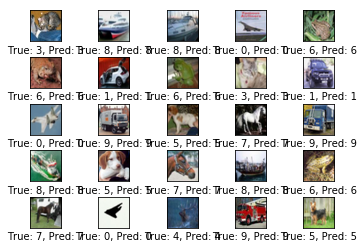

In [19]:
plot_images(x=x_test[:25], y_true=y_test[:25], y_pred=y_pred[:25])

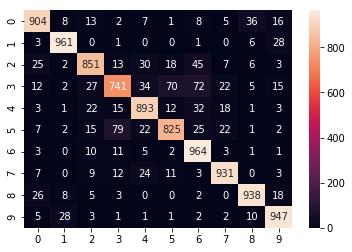

In [20]:
y_result = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(pd.DataFrame(y_result, range(10), range(10)), annot=True, fmt='g')